In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15460, done.
remote: Total 15460 (delta 0), reused 0 (delta 0), pack-reused 15460
Receiving objects: 100% (15460/15460), 14.07 MiB | 23.74 MiB/s, done.
Resolving deltas: 100% (10387/10387), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
  

In [ ]:
!./darknet detector train "/content/gdrive/My Drive/demo/obj.data" "/content/gdrive/My Drive/demo/csp.cfg" "/content/gdrive/My Drive/demo/yolo_model_cspnet/csp_last.weights" -dont_show 

Streaming output truncated to the last 5000 lines.
 total_bbox = 81659, rewritten_bbox = 0.025717 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.877683), count: 1, class_loss = 0.090895, iou_loss = 0.031193, total_loss = 0.122088 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.791699), count: 2, class_loss = 0.305721, iou_loss = 0.232411, total_loss = 0.538132 
 total_bbox = 81662, rewritten_bbox = 0.025716 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.889080), count: 1, class_loss = 0.255240, iou_loss = 0.024843, total_loss = 0.280082 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.773960), count: 6, class_loss = 2.911982, iou_loss = 1.069293, total_loss = 3.981275 
v3 (

In [4]:
#prediction
!pip install opencv-python==4.5.1.48

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50.4 MB 84 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66


predicted class => salute: 0.9637


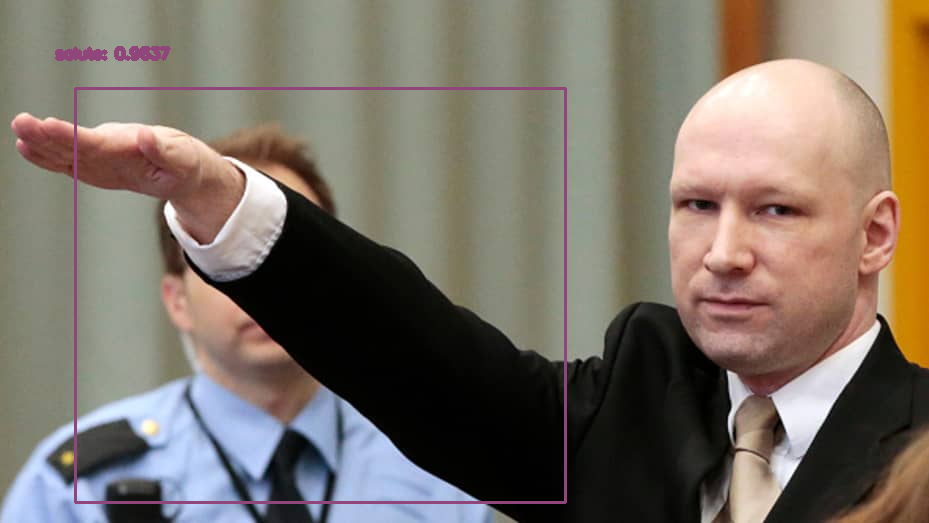

In [2]:
import numpy as np
import time
import cv2
import glob
from google.colab.patches import cv2_imshow

OUTPUT_FILE='predicted.png'
LABELS_FILE='/content/gdrive/My Drive/demo/obj.names'
CONFIG_FILE='/content/gdrive/My Drive/demo/csp.cfg'
WEIGHTS_FILE='/content/gdrive/My Drive/demo/yolo_model_cspnet/csp_last.weights'
CONFIDENCE_THRESHOLD = 0.1


INPUT_FILE='/content/gdrive/My Drive/demo/test.jpg'
#INPUT_FILE = input("Please enter the path of the image : ")
#print(f"You have entered the path => {INPUT_FILE} \n")

try:
  LABELS = open(LABELS_FILE).read().strip().split("\n")

  np.random.seed(4)
  COLORS = np.random.randint(1, 255, size=(len(LABELS), 3), dtype="uint8")


  net = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)

  image = cv2.imread(INPUT_FILE)
  (H, W) = image.shape[:2]

  # determine only the *output* layer names that we need from YOLO
  ln = net.getLayerNames()
  ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]


  blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
  net.setInput(blob)
  start = time.time()
  layerOutputs = net.forward(ln)
  end = time.time()


  #print("[INFO] YOLO took {:.6f} seconds".format(end - start))


  # initialize our lists of detected bounding boxes, confidences, and
  # class IDs, respectively
  boxes = []
  confidences = []
  classIDs = []

  # loop over each of the layer outputs
  for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
      # extract the class ID and confidence (i.e., probability) of
      # the current object detection
      scores = detection[5:]
      classID = np.argmax(scores)
      confidence = scores[classID]

      # filter out weak predictions by ensuring the detected
      # probability is greater than the minimum probability
      if confidence > CONFIDENCE_THRESHOLD:
        # scale the bounding box coordinates back relative to the
        # size of the image, keeping in mind that YOLO actually
        # returns the center (x, y)-coordinates of the bounding
        # box followed by the boxes' width and height
        box = detection[0:4] * np.array([W, H, W, H])
        (centerX, centerY, width, height) = box.astype("int")

        # use the center (x, y)-coordinates to derive the top and
        # and left corner of the bounding box
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))

        # update our list of bounding box coordinates, confidences,
        # and class IDs
        boxes.append([x, y, int(width), int(height)])
        confidences.append(float(confidence))
        classIDs.append(classID)

  # apply non-maxima suppression to suppress weak, overlapping bounding
  # boxes
  idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD,
    CONFIDENCE_THRESHOLD)

  # ensure at least one detection exists
  if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
      # extract the bounding box coordinates
      (x, y) = (boxes[i][0], boxes[i][1])
      (w, h) = (boxes[i][2], boxes[i][3])

      color = [int(c) for c in COLORS[classIDs[i]]]

      cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
      text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
      print(f'predicted class => {text}')
      cv2.putText(image, text, (x-20, y - 30), cv2.FONT_HERSHEY_SIMPLEX,
        0.5, color, 3)

    # show the output image
    
    
    cv2.imwrite('/content/gdrive/My Drive/demo/output.png', image)
    cv2_imshow(image)
except Exception as e:
  print("Exception while predicting", e)